**Melika Najkar**

Final project - Motion lab

In [46]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from skimage import draw as drw
from skimage import data, color, exposure, img_as_float, img_as_ubyte, morphology, filters
from skimage import io

import skimage
%matplotlib inline

In [13]:
!pip install pykalman

## 1- Background - Reference image
Let's visualize an empty scene captured by a fixed camera, and the same scene where objects are present

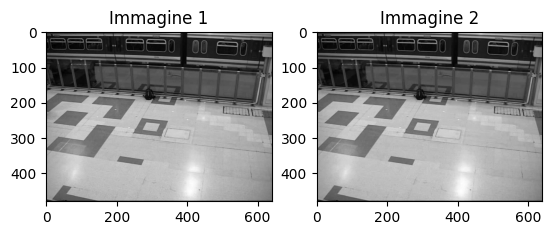

In [47]:
filename='/content/EmptyScene01.jpg'
I1=io.imread(filename)
filename='/content/EmptyScene02.jpg'
I2=io.imread(filename)
Ig1=img_as_float(color.rgb2gray(I1))
Ig2=img_as_float(color.rgb2gray(I2))

plt.subplot(121)
plt.imshow(Ig1,cmap='gray')
plt.title('Immagine 1')
plt.subplot(122)
plt.imshow(Ig2,cmap='gray')
plt.title('Immagine 2');

Let's try to see the difference in terms of Grayscale intensities of corresponding pixels across the two images

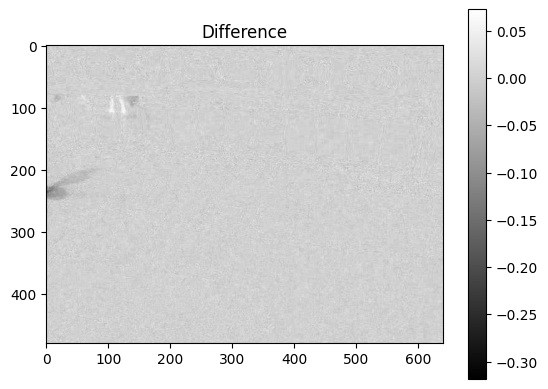

In [48]:
D = Ig1 - Ig2

plt.imshow(D,cmap='gray')
plt.title('Difference')
plt.colorbar()
plt.show()

Indeed, the difference seems to be small for most pixels:

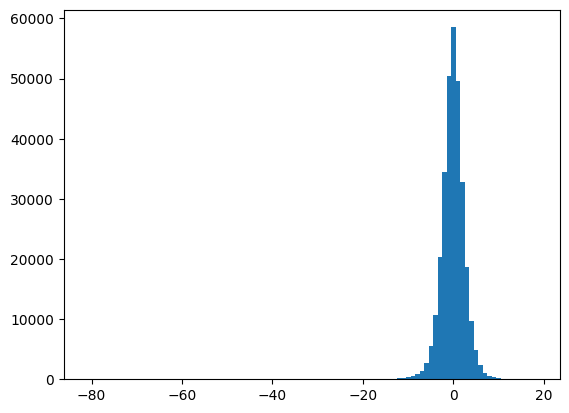

In [49]:
# multiplying by 255 to get a feeling of the differences entity
# with respect to input values
plt.hist(255*D.ravel(),100);

## 2- Change detection


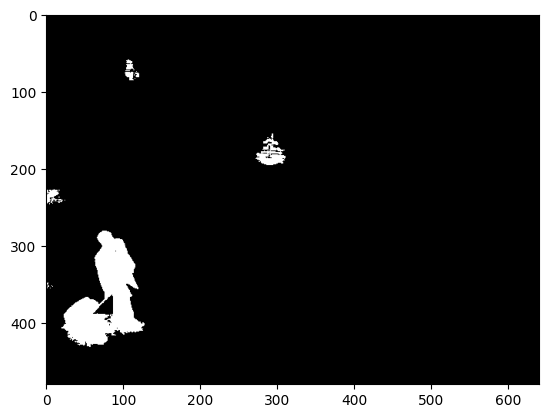

In [50]:
threshold=0.1 #let's pick a threshold
filename='/content/frame0250.jpg'
It=io.imread(filename)
Itg=img_as_float(color.rgb2gray(It))
# check slide "Motion segmentation - CHANGE DETECTION"
Dabs=( abs(Ig1 - Itg)> threshold)
plt.imshow(Dabs,cmap='gray')
plt.show()

# **3-Finding trajectory by applying Kalman filter and connected components**

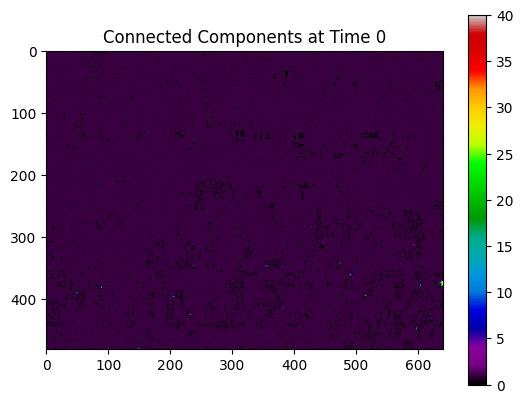

Centroids at Time 0: [(219.93757137370764, -1.9360307630804912), (0.0, 87.0), (51.0, 633.0), (52.0, 634.0), (58.0, 630.0), (121.0, 58.0), (211.0, 281.0), (212.0, 268.0), (237.0, 232.0), (251.0, 627.0), (252.0, 628.0), (282.0, 428.0), (309.0, 445.5), (310.00000000000006, 236.0), (312.0, 593.0), (325.0, 332.5), (341.0, 473.0), (344.0, 237.0), (345.0, 357.0), (345.5, 379.75), (346.0, 355.0), (353.0, 494.0), (359.0, 491.0), (360.0, 490.0), (365.0, 494.0), (378.8349664775656, 636.7106756059825), (373.0, 598.0), (376.5, 603.0), (379.99999999999994, 89.00000000000001), (388.0, 49.0), (389.0, 50.0), (393.0, 514.0), (394.75, 205.25), (394.0, 515.0), (407.0, 263.0), (412.0, 381.0), (424.0, 232.0), (424.0, 617.0), (446.0, 597.0), (479.0, 148.0)]


In [51]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects, center_of_mass
from scipy.spatial.distance import cdist
from pykalman import KalmanFilter

# Function to apply Kalman filter to the trajectories
def apply_kalman_filter(trajectories):
    filtered_trajectories = []
    for obj_id, traj in enumerate(trajectories):
        if len(traj) > 1:
            measurements = np.array(traj)
            initial_state = np.hstack((measurements[0], [0, 0]))  # Initial state with zero velocity
            transition_matrix = [[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]]
            observation_matrix = [[1, 0, 0, 0], [0, 1, 0, 0]]

            kf = KalmanFilter(transition_matrices=transition_matrix, observation_matrices=observation_matrix,
                              initial_state_mean=initial_state, n_dim_obs=2)

            state_means, state_covariances = kf.smooth(measurements)
            filtered_trajectories.append(state_means)
        else:
            filtered_trajectories.append(traj)
    return filtered_trajectories

# Sample binary maps from change detection at different time steps (replace with actual binary maps)
binary_maps = [D]  # Assume D is the binary difference map from previous analysis

# Store centroids and bounding boxes for each frame
object_trajectories = []

for t, binary_map in enumerate(binary_maps):
    # Label connected components
    labeled_array, num_features = label(binary_map)

    # Find bounding boxes and centroids of connected components
    objects_slices = find_objects(labeled_array)
    centroids = center_of_mass(binary_map, labeled_array, range(1, num_features+1))

    # Store results for this frame
    frame_info = {
        'frame': t,
        'num_features': num_features,
        'objects_slices': objects_slices,
        'centroids': centroids
    }
    object_trajectories.append(frame_info)

    # Plot the labeled components
    plt.figure()
    plt.imshow(labeled_array, cmap='nipy_spectral')
    plt.title(f'Connected Components at Time {t}')
    plt.colorbar()
    plt.show()

    # Print centroids for this frame
    print(f'Centroids at Time {t}: {centroids}')

# Define a distance threshold for tracking
some_threshold = 50  # Adjust based on the scale of your image and object sizes



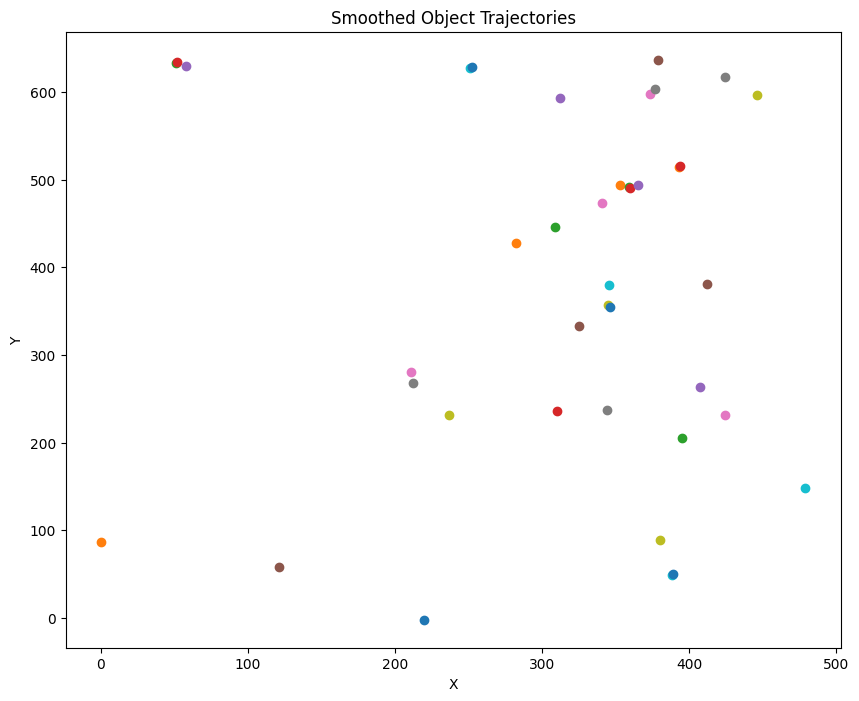

In [19]:

# Function to apply Kalman filter to the trajectories
def apply_kalman_filter(trajectories):
    filtered_trajectories = []
    for obj_id, traj in enumerate(trajectories):
        if len(traj) > 1:
            measurements = np.array(traj)
            initial_state = np.hstack((measurements[0], [0, 0]))  # Initial state with zero velocity
            transition_matrix = [[1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0], [0, 0, 0, 1]]
            observation_matrix = [[1, 0, 0, 0], [0, 1, 0, 0]]

            kf = KalmanFilter(transition_matrices=transition_matrix, observation_matrices=observation_matrix,
                              initial_state_mean=initial_state, n_dim_obs=2)

            state_means, state_covariances = kf.smooth(measurements)
            filtered_trajectories.append(state_means)
        else:
            filtered_trajectories.append(traj)
    return filtered_trajectories

# Sample binary maps from change detection at different time steps (replace with actual binary maps)
binary_maps = [D]  # Assume D is the binary difference map from previous analysis

# Track objects based on centroids
trajectories = []

for t, binary_map in enumerate(binary_maps):
    labeled_array, num_features = label(binary_map)
    centroids = center_of_mass(binary_map, labeled_array, range(1, num_features + 1))

    if t == 0:
        # Initialize trajectories with first frame centroids
        trajectories = [[centroid] for centroid in centroids]
    else:
        # Match centroids with previous frame and update trajectories
        prev_centroids = [traj[-1] for traj in trajectories]
        if centroids:
            dist_matrix = cdist(prev_centroids, centroids)
            for i, prev_centroid in enumerate(prev_centroids):
                closest_centroid_idx = np.argmin(dist_matrix[i])
                if dist_matrix[i][closest_centroid_idx] < some_threshold:  # Define a distance threshold
                    trajectories[i].append(centroids[closest_centroid_idx])
                else:
                    trajectories[i].append(prev_centroid)  # Assume object remains at the last position
        else:
            for i in range(len(trajectories)):
                trajectories[i].append(trajectories[i][-1])  # Assume all objects remain at last position

        # Print the distance matrix
        print(f'Distance matrix between frames {t-1} and {t}:\n{dist_matrix}')

# Apply Kalman filter to smooth the trajectories
filtered_trajectories = apply_kalman_filter(trajectories)

# Plot the smoothed trajectories
plt.figure(figsize=(10, 8))
for traj in filtered_trajectories:
    traj = np.array(traj)
    plt.plot(traj[:, 0], traj[:, 1], marker='o')
plt.title('Smoothed Object Trajectories')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


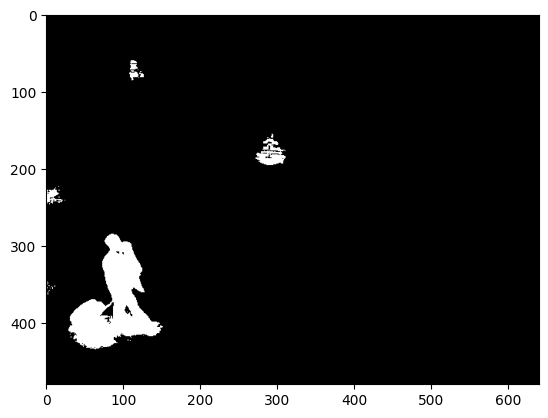

In [20]:
#try another frame
threshold = 0.1 #let's pick a threshold
filename='/content/frame0252.jpg'
It=io.imread(filename)
Itg=img_as_float(color.rgb2gray(It))
# check slide "Motion segmentation - CHANGE DETECTION"
Dabs=( abs(Ig1 - Itg)> threshold)
plt.imshow(Dabs,cmap='gray')
plt.show()

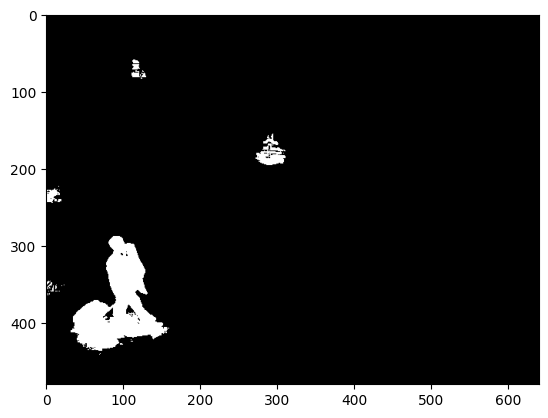

In [21]:
threshold = 0.1 #let's pick a threshold
filename='/content/frame0253.jpg'
It=io.imread(filename)
Itg=img_as_float(color.rgb2gray(It))
# check slide "Motion segmentation - CHANGE DETECTION"
Dabs=( abs(Ig1 - Itg)> threshold)
plt.imshow(Dabs,cmap='gray')
plt.show()

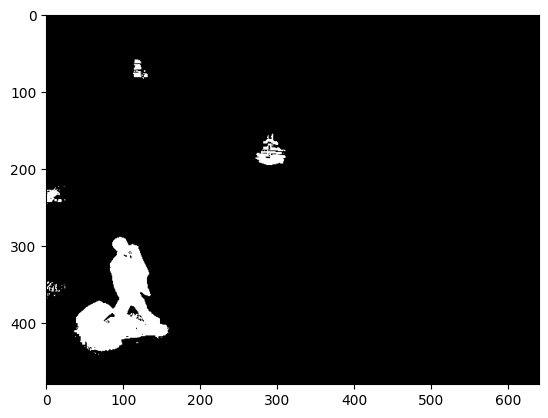

In [22]:
threshold = 0.1 #let's pick a threshold
filename='/content/frame0254.jpg'
It=io.imread(filename)
Itg=img_as_float(color.rgb2gray(It))
# check slide "Motion segmentation - CHANGE DETECTION"
Dabs=( abs(Ig1 - Itg)> threshold)
plt.imshow(Dabs,cmap='gray')
plt.show()

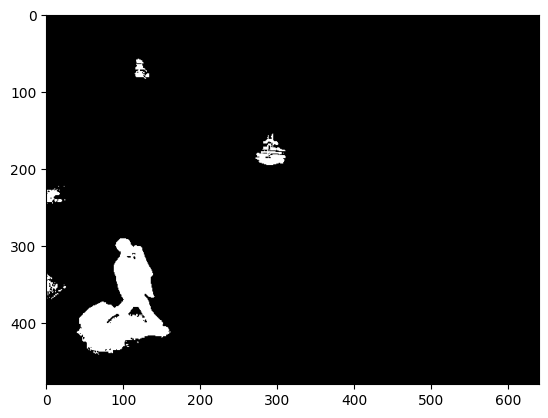

In [23]:
threshold = 0.1 #let's pick a threshold
filename='/content/frame0255.jpg'
It=io.imread(filename)
Itg=img_as_float(color.rgb2gray(It))
# check slide "Motion segmentation - CHANGE DETECTION"
Dabs=( abs(Ig1 - Itg)> threshold)
plt.imshow(Dabs,cmap='gray')
plt.show()

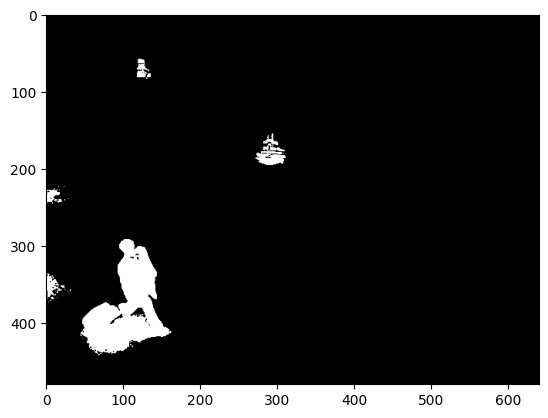

In [24]:
threshold = 0.1 #let's pick a threshold
filename='/content/frame0256.jpg'
It=io.imread(filename)
Itg=img_as_float(color.rgb2gray(It))
# check slide "Motion segmentation - CHANGE DETECTION"
Dabs=( abs(Ig1 - Itg)> threshold)
plt.imshow(Dabs,cmap='gray')
plt.show()

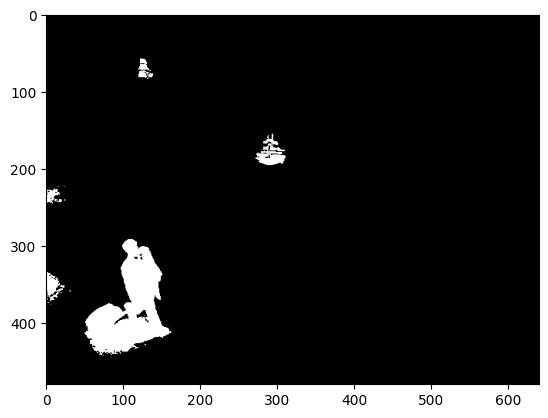

In [25]:
threshold = 0.1 #let's pick a threshold
filename='/content/frame0257.jpg'
It=io.imread(filename)
Itg=img_as_float(color.rgb2gray(It))
# check slide "Motion segmentation - CHANGE DETECTION"
Dabs=( abs(Ig1 - Itg)> threshold)
plt.imshow(Dabs,cmap='gray')
plt.show()

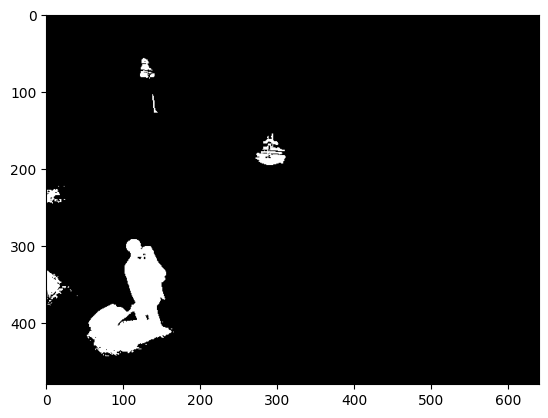

In [26]:
threshold = 0.1 #let's pick a threshold
filename='/content/frame0258.jpg'
It=io.imread(filename)
Itg=img_as_float(color.rgb2gray(It))
# check slide "Motion segmentation - CHANGE DETECTION"
Dabs=( abs(Ig1 - Itg)> threshold)
plt.imshow(Dabs,cmap='gray')
plt.show()

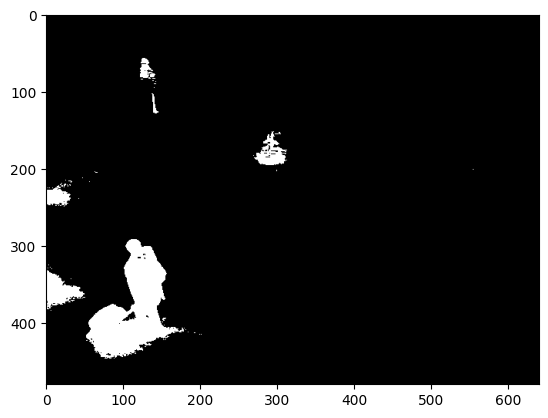

In [27]:
 #let's pick a different threshold
threshold = 0.07
filename='/content/frame0258.jpg'
It=io.imread(filename)
Itg=img_as_float(color.rgb2gray(It))
# check slide "Motion segmentation - CHANGE DETECTION"
Dabs=( abs(Ig1 - Itg)> threshold)
plt.imshow(Dabs,cmap='gray')
plt.show()

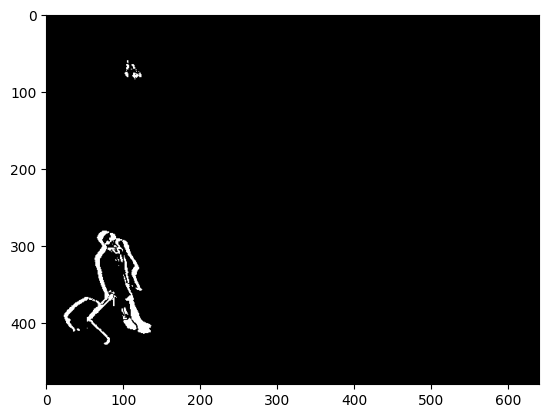

Pixel at (100, 200) is True


In [28]:
#now we detect the changes in two frame in a row, e.g. frames 251 and 252
threshold=0.1 #let's pick a threshold
filename='/content/frame0250.jpg'
It=io.imread(filename)
Itg=img_as_float(color.rgb2gray(It))
filename1='/content/frame0251.jpg'
It1=io.imread(filename1)
Itg1=img_as_float(color.rgb2gray(It1))
# check slide "Motion segmentation - CHANGE DETECTION"
Dabs=( abs(Itg - Itg1)> threshold)
plt.imshow(Dabs,cmap='gray')
plt.show()

# Find coordinates of a pixel where Dabs is True
target_pixel = (100, 200)  # example coordinates, change it to your desired pixel

# Loop over the coordinates of the pixel
for y in range(Dabs.shape[0]):
    for x in range(Dabs.shape[1]):
        if (x, y) == target_pixel:
            print(f"Pixel at ({x}, {y}) is True")


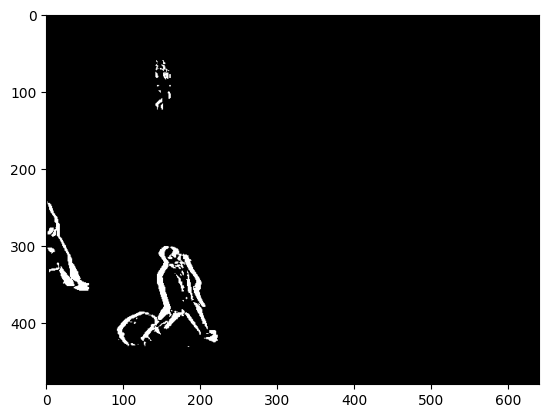

Pixel at (100, 200) is True


In [29]:
#now we detect the changes in another two frame in a row, e.g. frames 266 and 267
threshold=0.1 #let's pick a threshold
filename='/content/frame0266.jpg'
It=io.imread(filename)
Itg=img_as_float(color.rgb2gray(It))
filename1='/content/frame0267.jpg'
It1=io.imread(filename1)
Itg1=img_as_float(color.rgb2gray(It1))
# check slide "Motion segmentation - CHANGE DETECTION"
Dabs=( abs(Itg - Itg1)> threshold)
plt.imshow(Dabs,cmap='gray')
plt.show()

# Find coordinates of a pixel where Dabs is True
target_pixel = (100, 200)  # example coordinates, change it to your desired pixel

# Loop over the coordinates of the pixel
for y in range(Dabs.shape[0]):
    for x in range(Dabs.shape[1]):
        if (x, y) == target_pixel:
            print(f"Pixel at ({x}, {y}) is True")

## 4- Histograms
Have a look at the histogram of the differences to pick a better threshold

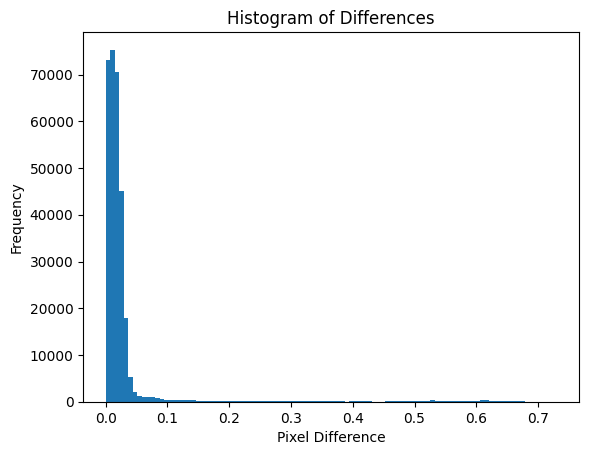

In [30]:
threshold = 0.1
filename = '/content/frame0264.jpg'

It = io.imread(filename)
Itg = img_as_float(color.rgb2gray(It))

# Calculate the absolute differences between the images
D = abs(Ig1 - Itg)

# Plot the histogram of the differences
plt.hist(D.ravel(), bins=100)
plt.xlabel('Pixel Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Differences')
plt.show()

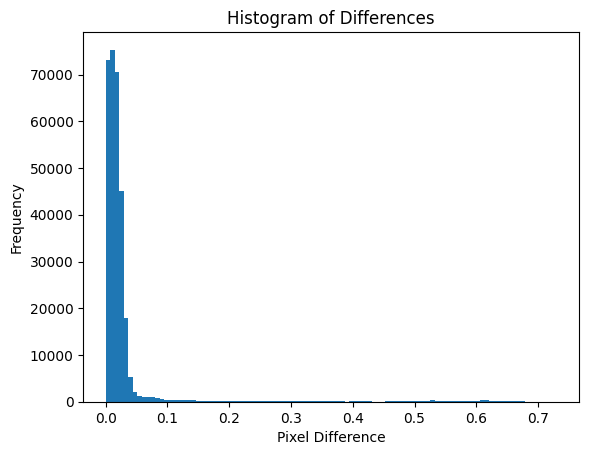

In [31]:
#lets pick another threshold
threshold = 0.4
filename = '/content/frame0264.jpg'

It = io.imread(filename)
Itg = img_as_float(color.rgb2gray(It))

# Calculate the absolute differences between the images
D = abs(Ig1 - Itg)

# Plot the histogram of the differences
plt.hist(D.ravel(), bins=100)
plt.xlabel('Pixel Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Differences')
plt.show()

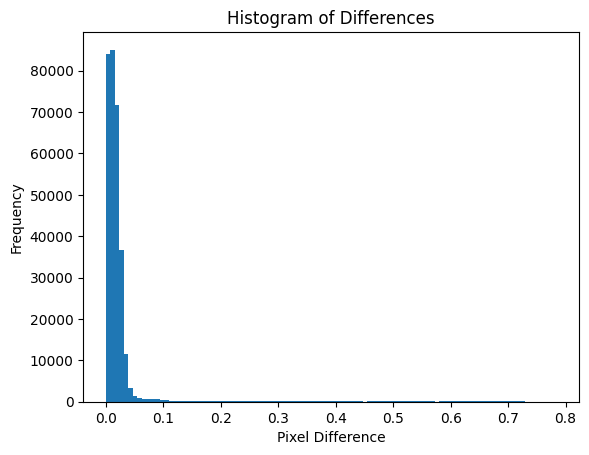

In [32]:
threshold = 0.1
filename = '/content/frame0258.jpg'

It = io.imread(filename)
Itg = img_as_float(color.rgb2gray(It))

# Calculate the absolute differences between the images
D = abs(Ig1 - Itg)

# Plot the histogram of the differences
plt.hist(D.ravel(), bins=100)
plt.xlabel('Pixel Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Differences')
plt.show()

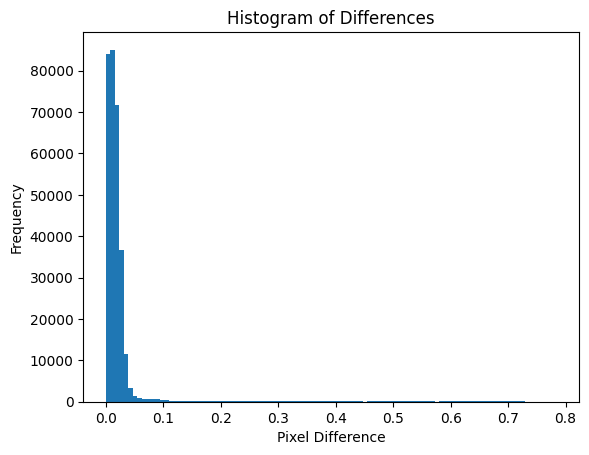

In [33]:
threshold = 0.6
filename = '/content/frame0258.jpg'

It = io.imread(filename)
Itg = img_as_float(color.rgb2gray(It))

# Calculate the absolute differences between the images
D = abs(Ig1 - Itg)

# Plot the histogram of the differences
plt.hist(D.ravel(), bins=100)
plt.xlabel('Pixel Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Differences')
plt.show()

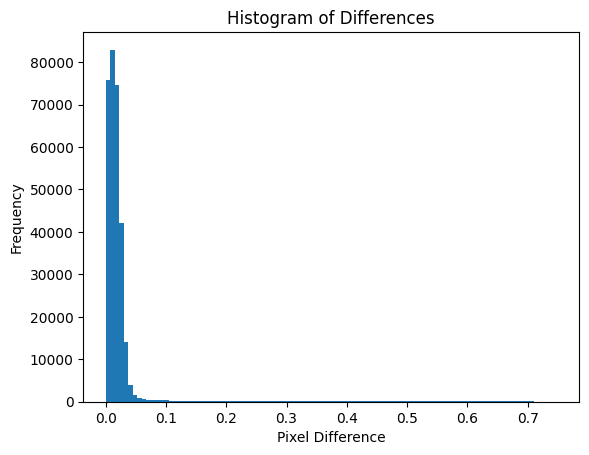

In [34]:
threshold = 0.15
filename = '/content/frame0251.jpg'

It = io.imread(filename)
Itg = img_as_float(color.rgb2gray(It))

# Calculate the absolute differences between the images
D = abs(Ig1 - Itg)

# Plot the histogram of the differences
plt.hist(D.ravel(), bins=100)
plt.xlabel('Pixel Difference')
plt.ylabel('Frequency')
plt.title('Histogram of Differences')
plt.show()

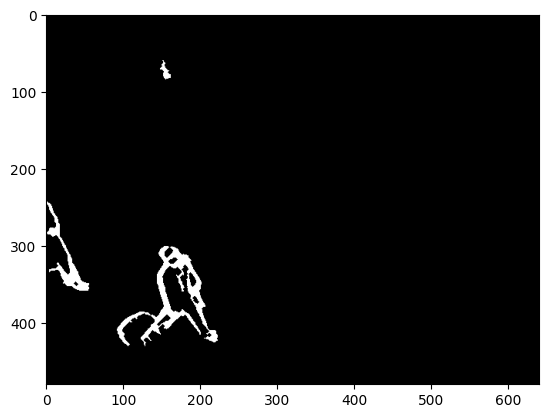

In [35]:
from skimage import morphology as mp
from skimage import data, util
from skimage.measure import label

mask=mp.disk(2) # the structuring element size controls the filling/deletion scale

Dabs=mp.closing(Dabs,mask)
Dabs=skimage.morphology.remove_small_objects(Dabs,100)
plt.imshow(Dabs,cmap='gray')
plt.show()


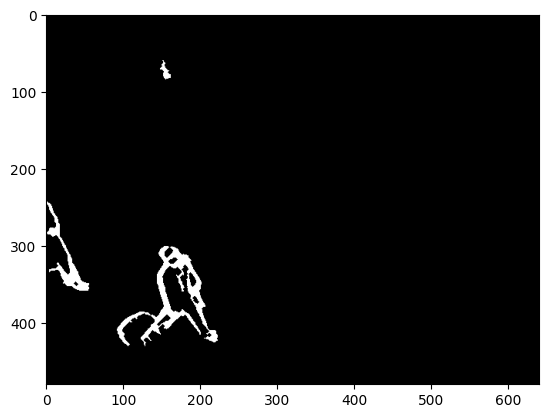

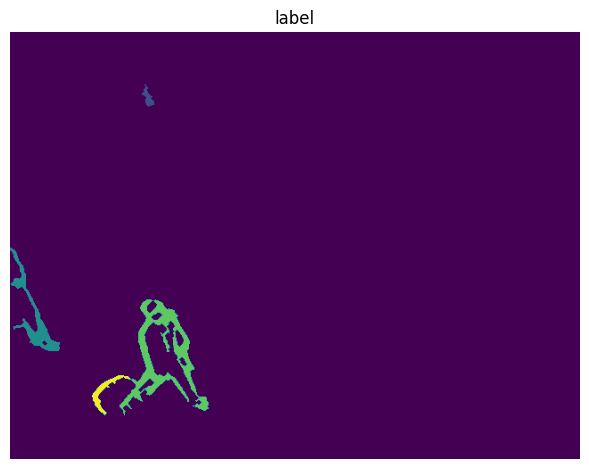

In [36]:
from skimage import morphology as mp
from skimage import data, util
from skimage.measure import label

mask=mp.disk(2) # the structuring element size controls the filling/deletion scale

Dabs=mp.closing(Dabs,mask)
Dabs=skimage.morphology.remove_small_objects(Dabs,100)
plt.imshow(Dabs,cmap='gray')
plt.show()

#for labeling connected components
from scipy import ndimage
labels, nb = ndimage.label(Dabs)

#plt.figure(figsize=(3.5, 3.5))
plt.imshow(labels)
plt.title('label')
plt.axis('off')

plt.subplots_adjust(wspace=.05, left=.01, bottom=.01, right=.99, top=.9)

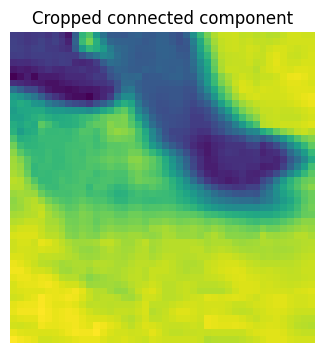

In [37]:
sl = ndimage.find_objects(labels==4)
plt.figure(figsize=(3.5, 3.5))
plt.imshow(Itg[sl[0]])
plt.title('Cropped connected component')
plt.axis('off')

plt.subplots_adjust(wspace=.05, left=.01, bottom=.01, right=.99, top=.9)

plt.show()

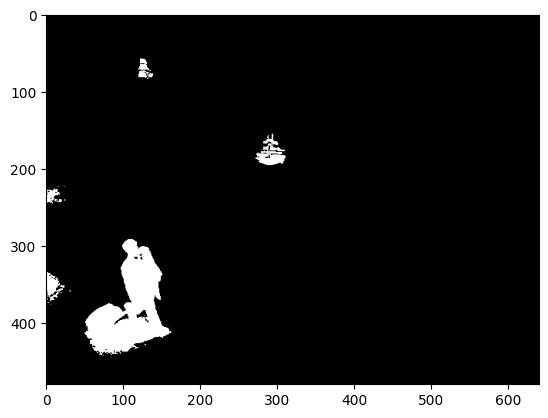

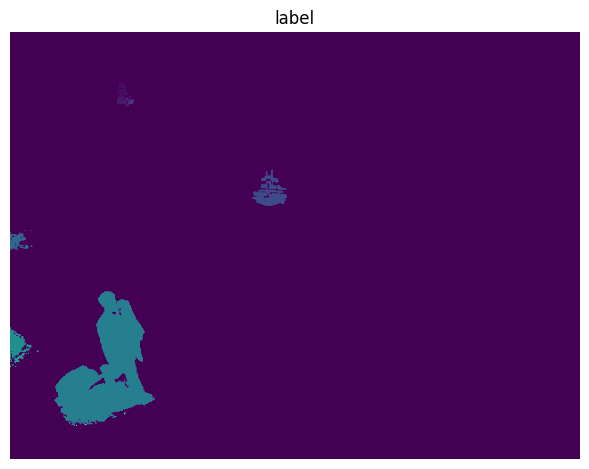

In [38]:
threshold = 0.1 #let's pick a threshold
filename='/content/frame0257.jpg'
It=io.imread(filename)
Itg=img_as_float(color.rgb2gray(It))
# check slide "Motion segmentation - CHANGE DETECTION"
Dabs=( abs(Ig1 - Itg)> threshold)
plt.imshow(Dabs,cmap='gray')
plt.show()

from scipy import ndimage
labels, nb = ndimage.label(Dabs)

#plt.figure(figsize=(3.5, 3.5))
plt.imshow(labels)
plt.title('label')
plt.axis('off')

plt.subplots_adjust(wspace=.05, left=.01, bottom=.01, right=.99, top=.9)

## 5- Trajectory

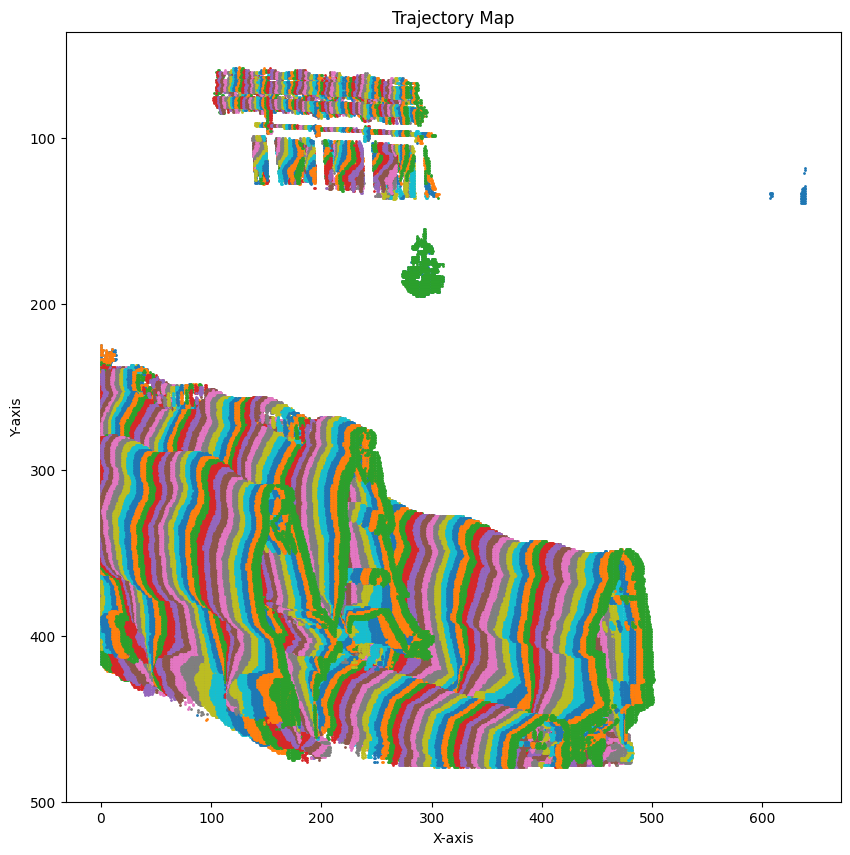

In [40]:
#find the trajectory for moving the object
import os
import numpy as np
from skimage import io, color, img_as_float
import matplotlib.pyplot as plt

# Define the directory containing images
directory = '/content/'

# Define the threshold
threshold = 0.1

# Get a sorted list of all jpg files in the directory
jpg_files = sorted([file for file in os.listdir(directory) if file.lower().endswith(('.jpg', '.jpeg'))])

# List to store Dabs arrays
dabs_list = []

# Loop over the image files in pairs
for i in range(len(jpg_files) - 1):
    # Read the current and next images
    filename = os.path.join(directory, jpg_files[i])
    filename1 = os.path.join(directory, jpg_files[i + 1])

    It = io.imread(filename)
    Itg = img_as_float(color.rgb2gray(It))

    It1 = io.imread(filename1)
    Itg1 = img_as_float(color.rgb2gray(It1))

    # Check for motion segmentation (change detection)
    Dabs = (abs(Itg - Itg1) > threshold)

    # Append the result to the list
    dabs_list.append(Dabs)

    #print(f"Processed {filename} and {filename1}")

# Initialize lists to store trajectory points
trajectory_points = []

# Extract the coordinates of moving points
for Dabs in dabs_list:
    coordinates = np.column_stack(np.where(Dabs))
    trajectory_points.append(coordinates)

# Plot the trajectory map
plt.figure(figsize=(10, 10))
for points in trajectory_points:
    if points.size > 0:
        plt.scatter(points[:, 1], points[:, 0], s=1)

plt.gca().invert_yaxis()
plt.title('Trajectory Map')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


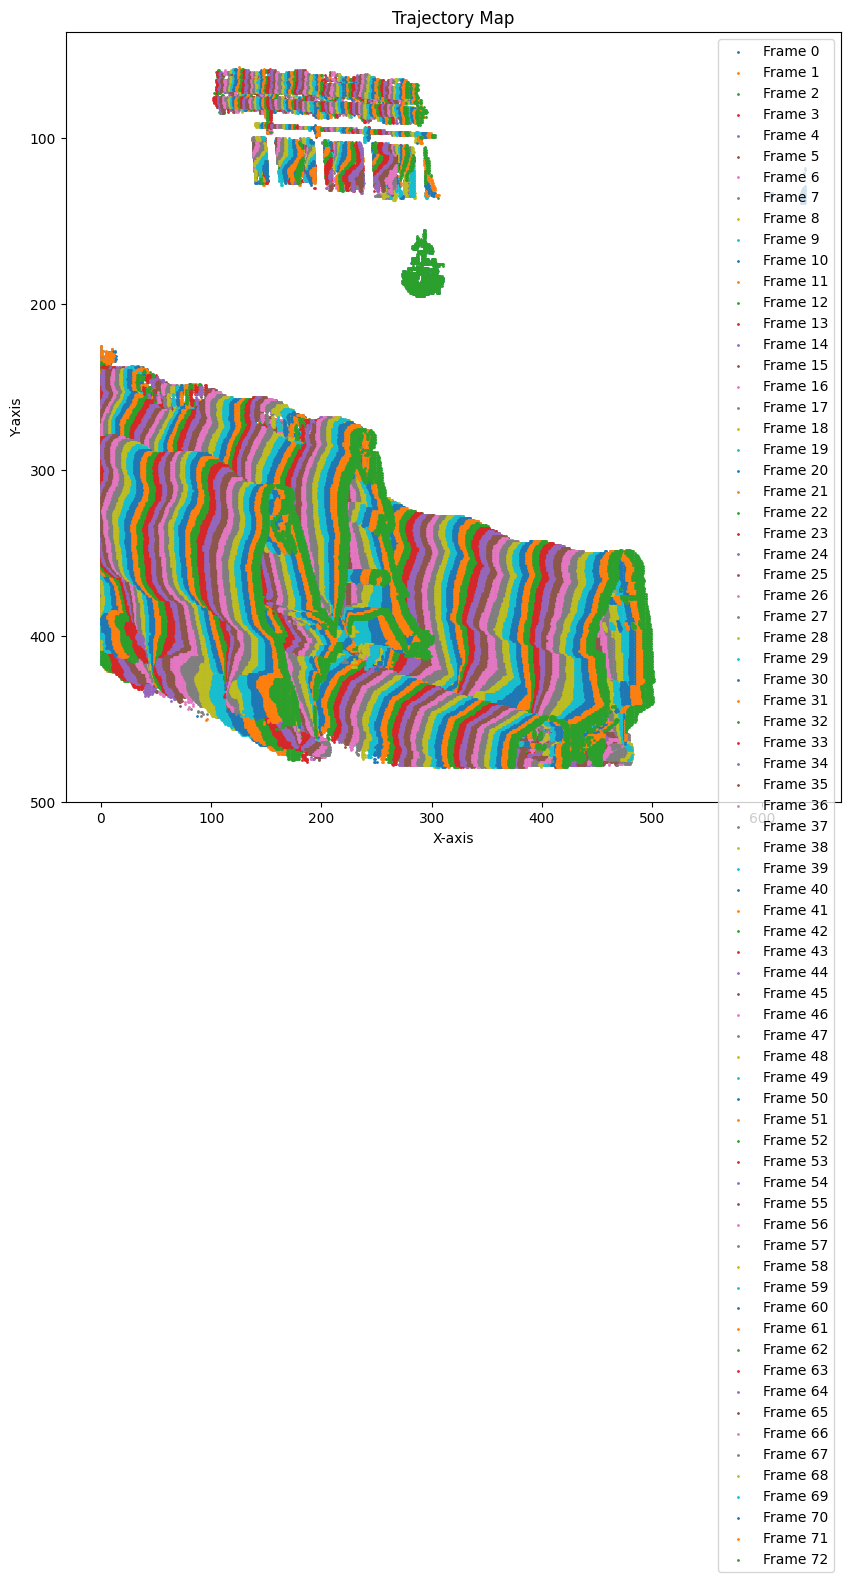

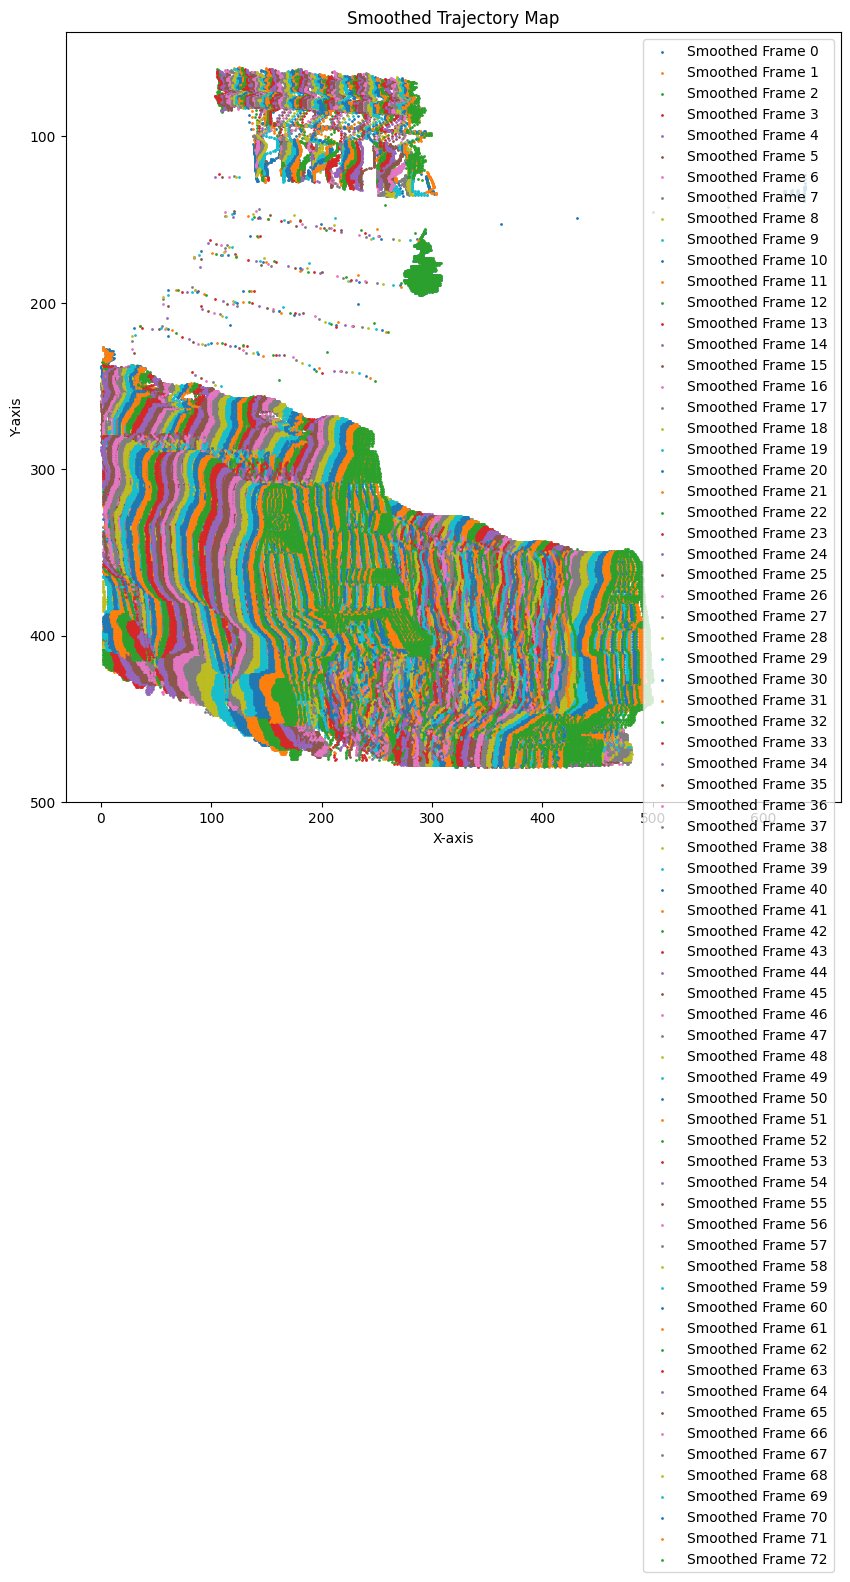

In [41]:
#smoothing the trajectory had been obtained
import os
import numpy as np
from skimage import io, color, img_as_float
import matplotlib.pyplot as plt

# Define the directory containing images
directory = '/content/'

# Define the threshold
threshold = 0.1

# Get a sorted list of all jpg files in the directory
jpg_files = sorted([file for file in os.listdir(directory) if file.lower().endswith(('.jpg', '.jpeg'))])

# List to store Dabs arrays
dabs_list = []

# Loop over the image files in pairs
for i in range(len(jpg_files) - 1):
    # Read the current and next images
    filename = os.path.join(directory, jpg_files[i])
    filename1 = os.path.join(directory, jpg_files[i + 1])

    It = io.imread(filename)
    Itg = img_as_float(color.rgb2gray(It))

    It1 = io.imread(filename1)
    Itg1 = img_as_float(color.rgb2gray(It1))

    # Check for motion segmentation (change detection)
    Dabs = (abs(Itg - Itg1) > threshold)

    # Append the result to the list
    dabs_list.append(Dabs)

    #print(f"Processed {filename} and {filename1}")

# Initialize lists to store trajectory points
trajectory_points = []

# Extract the coordinates of moving points
for Dabs in dabs_list:
    coordinates = np.column_stack(np.where(Dabs))
    trajectory_points.append(coordinates)

# Save trajectory data
#np.save('trajectory_points.npy', trajectory_points)

# Plot the trajectory map with customizations
plt.figure(figsize=(10, 10))
for i, points in enumerate(trajectory_points):
    if points.size > 0:
        plt.scatter(points[:, 1], points[:, 0], s=1, label=f'Frame {i}')

plt.gca().invert_yaxis()
plt.title('Trajectory Map')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

# Smoothing the trajectory points (example with simple moving average)
smoothed_trajectory_points = []

for points in trajectory_points:
    if points.size > 0:
        smoothed_points = np.apply_along_axis(lambda x: np.convolve(x, np.ones(5)/5, mode='valid'), axis=0, arr=points)
        smoothed_trajectory_points.append(smoothed_points)

# Plot the smoothed trajectory map
plt.figure(figsize=(10, 10))
for i, points in enumerate(smoothed_trajectory_points):
    if points.size > 0:
        plt.scatter(points[:, 1], points[:, 0], s=1, label=f'Smoothed Frame {i}')

plt.gca().invert_yaxis()
plt.title('Smoothed Trajectory Map')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

<ipython-input-42-08be1aff08fb>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('viridis')  # Choose a colormap


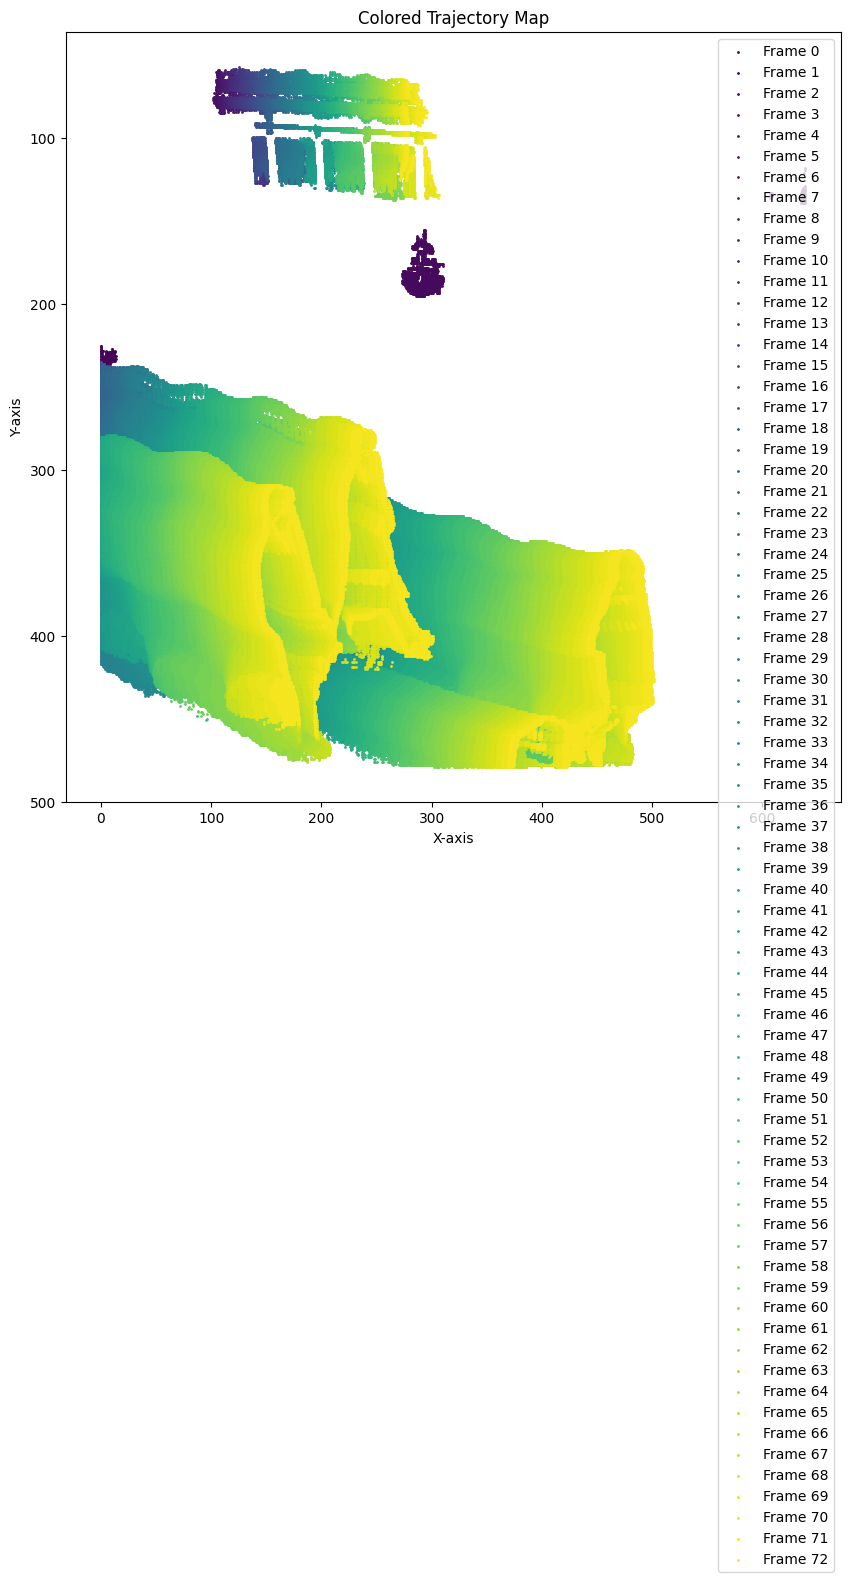

In [42]:
#Plotting Trajectory Points with Colors
from matplotlib.cm import get_cmap

cmap = get_cmap('viridis')  # Choose a colormap

plt.figure(figsize=(10, 10))
for i, points in enumerate(trajectory_points):
    if points.size > 0:
        plt.scatter(points[:, 1], points[:, 0], s=1, color=cmap(i / len(trajectory_points)), label=f'Frame {i}')

plt.gca().invert_yaxis()
plt.title('Colored Trajectory Map')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

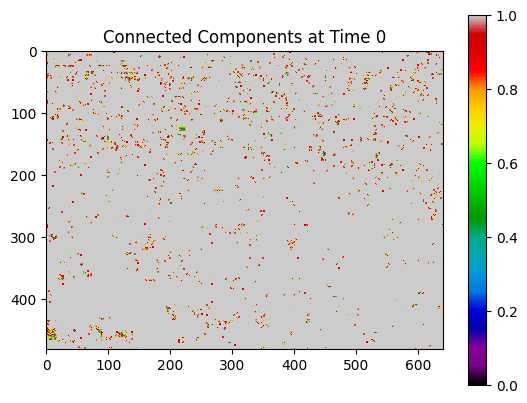

Centroids at Time 0: [(299.6484453253244, 227.2721058576912)]


In [43]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects, center_of_mass
from scipy.spatial.distance import cdist

# Sample binary maps from change detection at different time steps (replace with actual binary maps)
binary_maps = [D]  # Assume D is the binary difference map from previous analysis

# Store centroids and bounding boxes for each frame
object_trajectories = []

for t, binary_map in enumerate(binary_maps):
    # Label connected components
    labeled_array, num_features = label(binary_map)

    # Find bounding boxes and centroids of connected components
    objects_slices = find_objects(labeled_array)
    centroids = center_of_mass(binary_map, labeled_array, range(1, num_features+1))

    # Store results for this frame
    frame_info = {
        'frame': t,
        'num_features': num_features,
        'objects_slices': objects_slices,
        'centroids': centroids
    }
    object_trajectories.append(frame_info)

    # Plot the labeled components
    plt.figure()
    plt.imshow(labeled_array, cmap='nipy_spectral')
    plt.title(f'Connected Components at Time {t}')
    plt.colorbar()
    plt.show()

    # Print centroids for this frame
    print(f'Centroids at Time {t}: {centroids}')

# Example: Track objects based on centroids
for t in range(1, len(object_trajectories)):
    prev_centroids = object_trajectories[t-1]['centroids']
    curr_centroids = object_trajectories[t]['centroids']

    # Calculate distance matrix between centroids of consecutive frames
    if prev_centroids and curr_centroids:
        dist_matrix = cdist(prev_centroids, curr_centroids)

        print(f'Distance matrix between frames {t-1} and {t}:\n{dist_matrix}')

    else:
        print(f'No centroids to compare between frames {t-1} and {t}')